# MNIST classification using Variational Quantum Classifier


* **Author**: yeray142 (Yeray C.)
* **Date**: 2023/09/16
* **Version**: 1.0
* **Description**: Variational Quantum Classifier model applied to MNIST dataset.

## Setup

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Part 1 - Data preprocessing

### Importing MNIST dataset

In [56]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


### Flattening the images to 1D array

In [57]:
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)
print(x_train_flattened.shape)

(60000, 784)


### Standardizing data

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_flattened_standardize = scaler.fit_transform(x_train_flattened)
x_test_flattened_standardize = scaler.transform(x_test_flattened)

### Dimensionality reduction

In [59]:
from sklearn.decomposition import KernelPCA

# Use t-SNE technique to reduce dimensions to 2
k_pca = KernelPCA(n_components=2, kernel='rbf')
train_data_features_reduced = k_pca.fit_transform(x_train_flattened_standardize)
test_data_features_reduced = k_pca.transform(x_test_flattened_standardize)

### Feature scaling

In [60]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [61]:
from sklearn.preprocessing import MinMaxScaler

X_train_pca_filtered, y_train_filtered = filter_36(train_data_features_reduced, y_train)
X_test_pca_filtered, y_test_filtered = filter_36(test_data_features_reduced, y_test)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train_pca_filtered)
X_test = sc.transform(X_test_pca_filtered)
X_train.shape

(12049, 2)

## Part 2 - Model training

### Feature map

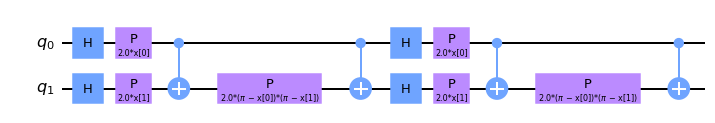

In [62]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2)
feature_map.decompose().draw(output="mpl", fold=30)

### Ansatz circuit

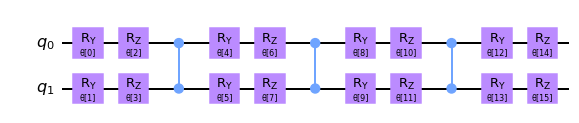

In [63]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(X_train.shape[1], ['ry', 'rz'], 'cz', reps=3)
ansatz.decompose().draw(output="mpl", fold=30)

### Optimization Algorithm

In [64]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=150)

### Define callback function

In [65]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Training model on train dataset

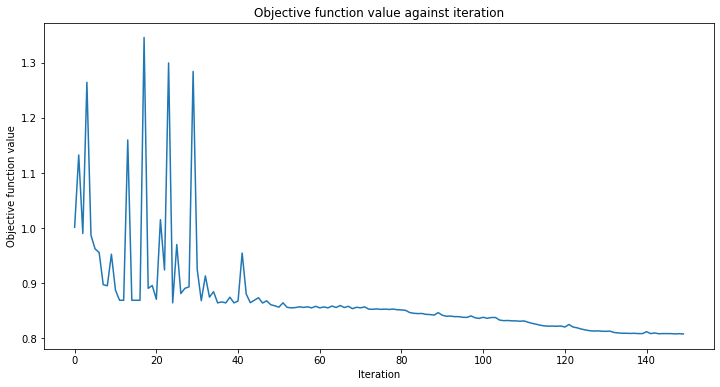

Training time: 53 seconds


In [66]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

train_size = 60
test_size = 10
X_train = X_train[:train_size]
y_train = y_train_filtered[:train_size]
X_test = X_test[:test_size]
y_test = y_test_filtered[:test_size]

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

## Part 4 - Testing on test dataset and evaluating model

In [67]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

y_pred = vqc.predict(X_test)
print(y_pred)

Quantum VQC on the training dataset: 0.73
Quantum VQC on the test dataset:     0.50
[ True  True False False False False  True  True  True  True]
